<a href="https://colab.research.google.com/github/rameshavinash94/Advanced-Keras/blob/main/PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INITIAL SETUP**

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Custom Learning Scheduler**

In [2]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

**Custom Dropout**

In [3]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

**Custom Normalization**

In [4]:
from functools import partial

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

**custom loss function**

In [5]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

**custom activation function**

In [65]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

def leaky_relu(z, alpha=0.01):
    return tf.maximum(alpha*z, z)

def tanh(x):
  return tf.keras.activations.tanh(x)

**Custom Metric**

In [7]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [8]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**Custom Layers**

In [9]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape


class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

**Custom Model**

In [10]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [11]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

**Custom optimizer**

In [12]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

**Let's use all the above in a dataset and just run and see**

In [13]:
import numpy as np
import matplotlib.pyplot as plot 

# Get x values of the sine wave
time = np.arange(0, 10, 0.4);
# Amplitude of the sine wave is sine of a variable like time
amplitude   = np.sin(time)

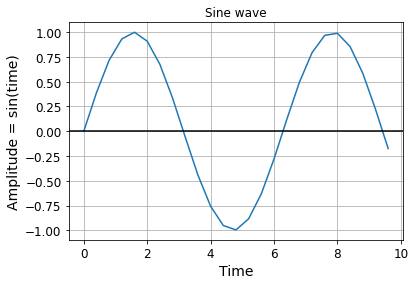

In [14]:
# Plot a sine wave using time and amplitude obtained for the sine wave
plot.plot(time, amplitude) 

# Give a title for the sine wave plot
plot.title('Sine wave')

# Give x axis label for the sine wave plot
plot.xlabel('Time')

# Give y axis label for the sine wave plot
plot.ylabel('Amplitude = sin(time)')
plot.grid(True, which='both')
plot.axhline(y=0, color='k')
plot.show()
# Display the sine wave

plot.show()

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(time, amplitude, test_size=0.10, random_state=40)

In [118]:
from keras.models import Sequential
from keras.layers import Dense

In [119]:
model = Sequential()
#add custom activation
model.add(Dense(13,input_dim=1, kernel_initializer='normal', activation=leaky_relu))
#add custom layer
model.add(MyDense(10))
#add custom normalization
#model.add(MaxNormDense(5))
model.add(Dense(1, kernel_initializer='normal',activation=tanh))
#add custom loss and custom optimizer
model.compile(loss=huber_fn, optimizer=MyMomentumOptimizer())

In [120]:
model.fit(X_train, y_train, epochs=500)

Epoch 1/500
1/1 [==============================] - 13s 13s/step - loss: 0.2549
Epoch 2/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2549
Epoch 3/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2549
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2548
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2548
Epoch 6/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2548
Epoch 7/500
1/1 [==============================] - 0s 18ms/step - loss: 0.2547
Epoch 8/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2547
Epoch 9/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2546
Epoch 10/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2545
Epoch 11/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2545
Epoch 12/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2544
Epoch 13/500
1/1 [==============================] - 0s 6ms

In [127]:
predictions = model.predict(X_test)

In [122]:
y_test

array([-0.2794155 , -0.17432678, -0.63126664])

In [123]:
score = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 122ms/step - loss: 0.1798


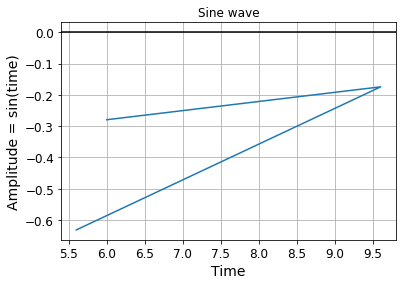

In [126]:
# Plot a sine wave using time and amplitude obtained for the sine wave
plot.plot(X_test, y_test) 

# Give a title for the sine wave plot
plot.title('Sine wave')

# Give x axis label for the sine wave plot
plot.xlabel('Time')

# Give y axis label for the sine wave plot
plot.ylabel('Amplitude = sin(time)')
plot.grid(True, which='both')
plot.axhline(y=0, color='k')
plot.show()
# Display the sine wave

plot.show()

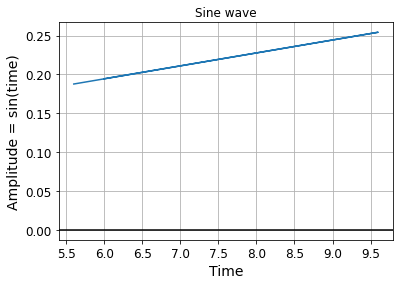

In [128]:
# Plot a sine wave using time and amplitude obtained for the sine wave
plot.plot(X_test, predictions) 

# Give a title for the sine wave plot
plot.title('Sine wave')

# Give x axis label for the sine wave plot
plot.xlabel('Time')

# Give y axis label for the sine wave plot
plot.ylabel('Amplitude = sin(time)')
plot.grid(True, which='both')
plot.axhline(y=0, color='k')
plot.show()
# Display the sine wave

plot.show()